In [1]:
from typing import List, Tuple, Sequence

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

sns.set_context("notebook", font_scale=1.)
sns.set_style("darkgrid")

In [2]:
def plot_ts(ts, title):
    """ Plot a time series. """
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(ts.index, ts, lw=2, label='SO2 concentration')
    ax.set_title(title, fontsize=30)
    ax.set_ylabel('{} values'.format(ts.name), fontsize=23)
    ax.set_xlabel('Timestamp', fontsize=23)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    fig.autofmt_xdate()

    return fig, ax


def plot_ma(ax, ts, ma_period):
    """ Plot a moving average for a time series in the given axes. """
    ma = ts.rolling(window=ma_period).mean()
    ax.plot(ts.index, ma, lw=1, label='{}-days MA'.format(ma_period))
    return ax


def plot_ts_ma(ts, ma_period, title):
    """ Plot a time series with its moving average given by the specified period. """
    fig, ax = plot_ts(ts, title)
    plot_ma(ax, ts, ma_period)
    ax.legend(fontsize=15)

    return fig, ax


def plot_ts_standard_mas(ts, title):
    """ Plot a time series with its moving average for 10, 20 and 50 days period. """
    ma_periods = [10, 25, 50]
    fig, ax = plot_ts(ts, title)
    for ma in ma_periods:
        plot_ma(ax, ts, ma)
    ax.legend(fontsize=15)

    return fig, ax


def plot_3d_clusters(data:np.array, y_kmeans:np.array):
    """ Plot clusters of data with 3 dimensions."""
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=y_kmeans, cmap='viridis')
    return fig, ax


def plot_ts_clusters_scatter(df, title):
    """ Plot clusters of data over time for SO2 pollutant measures. """
    clusters = df.groupby('y')
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    for name, c in clusters:
        ax.scatter(c.index, c['SO2'], label='Cluster {}'.format(name))

    ax.set_title(title, fontsize=30)
    ax.set_ylabel('SO2 values', fontsize=23)
    ax.set_xlabel('Timestamp', fontsize=23)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    ax.legend(fontsize=15)

    fig.autofmt_xdate()
    
    return fig, ax

In [3]:
def load_data(features:List) -> pd.DataFrame:
    """ Load the data set from the Huairou monitoring site and process
    it with a timestamp index, selecting the list of features passed as
    argument, upsampling to daily frequency measures and fillin the
    missing values with cubic interpolation. """
    
    print('Data: features={}'.format(features))
    df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset2.csv')
    df.index = pd.to_datetime({'Year': df['Year'],
                                       'Month': df['Month'],
                                       'Day': df['Day'],
                                       'Hour': df['Hour']})
    return pd.DataFrame(
        data=df[features].values, 
        index=df.index, 
        columns=features, 
        dtype=np.float32
    ).sort_index().resample('D').mean().interpolate(method='cubic')


def scale_data(data: np.ndarray) -> np.ndarray:
    """ Interface for scaling a data set. In the current version,
    standard scaling is done with scikit-learn. """
    
    return StandardScaler().fit_transform(data)
    
    
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """ Interface for pre-processing the data.
    Add pre-processing steps here. """
    
    df.loc[:] = scale_data(data=df.values)
    print('Data after pre-processing:')
    print(df)
    return df


def create_fit_model(x: np.ndarray, init: str, n_clusters: int, n_init: int):
    """ Interface for creating and tRaining a model. In the current
    version, k-means is used with scikit-learn. """
    
    print('Model parameters: init={}, n_clusters={}, n_init={}'
          .format(init, n_clusters, n_init))
    model = KMeans(init=init, n_clusters=n_clusters, n_init=n_init)
    model.fit(x)
    return model

    
def evaluate_model(name: str, model, x: np.ndarray) -> List:
    """ Interface for evaluating a model. In the current version,
    a k-means model is evaluated with scikit-learn. Silhouette Coefficient
    and Calinski-Harabasz index are used as evaluation metrics. """
    
    silhouette = metrics.silhouette_score(x, model.labels_,metric='euclidean')
    calinski = metrics.calinski_harabasz_score(x, model.labels_)
    print('init\t\tnfeat\tclusters inertia silhouette calinski')
    print('%-9s\t%i\t%i\t%i\t%.3f\t%.3f'
          % (name, x.shape[1], model.cluster_centers_.shape[0],
             model.inertia_, silhouette, calinski))
    return [name, x.shape[1], model.cluster_centers_.shape[0],
            model.inertia_, silhouette, calinski]


def test(name: str = '_', features: List = ['SO2', 'Temp', 'WinSpeed'], n_clusters: int = 4,
         init: str = 'k-means++', n_init: int = 10) -> Tuple[List, pd.DataFrame]:
    """ Performs a test given the arguments and returns the model evaluation
    results alongside the data used with the cluster labels. Loads data,
    pre-process data, creates and fits a model and evaluates the model. """
    
    print(40 * '_' + name + 40 * '_')
    print('LOADING DATA')
    df = load_data(features=features)
    print('PRE-PROCESSING DATA')
    df = preprocess_data(df=df)
    print('MODELLING')
    model = create_fit_model(x=df.values, init=init, n_clusters=n_clusters, n_init=n_init)
    print('EVALUATING')
    res = evaluate_model(name=name, model=model, x=df.values)
    df['y'] = model.predict(df)
    return (res, df)


def experiment(tests: Tuple[str, List] = [('default',['SO2', 'Temp', 'WinSpeed'])],
               clusters: Sequence = range(3, 6)):
    """ Performs a grid search hyperparameter tuning for the features
    and clusters specified as arguments. """
    
    res_list = []
    data_list = []
    for name, features in tests:
        for c in clusters:
            res, data = test(features=features, n_clusters=c, name=name)
            res_list.append(res)
            data_list.append(data)
    results = pd.DataFrame(res_list, columns=['name', 'nfeat', 'clusters',
                                              'inertia', 'silhouette', 'calinski'])
    return results, data_list

In [4]:
# Testing the code with a default experiment. Click 'Output' to show logs.
results, data_list = experiment()
results

________________________________________default________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp  WinSpeed
2013-03-01 -0.359238 -1.142360  1.689884
2013-03-02  0.943210 -1.226816 -0.831673
2013-03-03  1.958061 -0.764859 -0.379225
2013-03-04  0.175151 -0.361897  0.697165
2013-03-05  3.191951 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.245113
2017-02-25 -0.575057 -0.600023  0.457013
2017-02-26 -0.327664 -0.625093 -0.183132
2017-02-27  0.095320 -0.534153 -0.290810
2017-02-28 -0.487350 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	3	1801	0.440	1044.319
________________________________________default________________________________________
LOADING DATA
Data: features=['SO2', 'Temp'

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp  WinSpeed
2013-03-01 -0.359238 -1.142360  1.689884
2013-03-02  0.943210 -1.226816 -0.831673
2013-03-03  1.958061 -0.764859 -0.379225
2013-03-04  0.175151 -0.361897  0.697165
2013-03-05  3.191951 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.245113
2017-02-25 -0.575057 -0.600023  0.457013
2017-02-26 -0.327664 -0.625093 -0.183132
2017-02-27  0.095320 -0.534153 -0.290810
2017-02-28 -0.487350 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	4	1370	0.408	1067.018
________________________________________default________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp  WinSpeed
2013-03-01 -0.359238 -1.142360  1.689884
2013-03-02  0.943210 -1.226816 -0.831673
2013-03-03  1.958061 -0.764859 -0.379225
2013-03-04  0.175151 -0.361897  0.697165
2013-03-05  3.191951 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.245113
2017-02-25 -0.575057 -0.600023  0.457013
2017-02-26 -0.327664 -0.625093 -0.183132
2017-02-27  0.095320 -0.534153 -0.290810
2017-02-28 -0.487350 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	5	1180	0.362	987.200


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


,name,nfeat,clusters,inertia,silhouette,calinski
0,default,3,3,1801.823486,0.440214,1044.318508
1,default,3,4,1370.965454,0.408366,1067.017948
2,default,3,5,1180.749390,0.361926,987.200323


In [5]:
tests = [('SO2', ['SO2', 'Temp', 'WinSpeed']),
         ('with Press', ['SO2', 'Temp', 'Press', 'WinSpeed']),
         ('with DewP', ['SO2', 'Temp', 'DewP', 'WinSpeed']),
         ('with Rain', ['SO2', 'Temp', 'Rain', 'WinSpeed']),
         ('with Press DewP', ['SO2', 'Temp', 'Press', 'DewP', 'WinSpeed']),
         ('with Press Rain', ['SO2', 'Temp', 'Press', 'Rain', 'WinSpeed']),
         ('with DewP Rain', ['SO2', 'Temp', 'DewP', 'Rain', 'WinSpeed']),
         ('all', ['SO2', 'Temp', 'Press', 'DewP', 'Rain', 'WinSpeed'])]
clusters = range(2, 6)

# Click 'Output' to show logs.
results, data_list = experiment(tests=tests, clusters=clusters)

________________________________________SO2________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp  WinSpeed
2013-03-01 -0.359238 -1.142360  1.689884
2013-03-02  0.943210 -1.226816 -0.831673
2013-03-03  1.958061 -0.764859 -0.379225
2013-03-04  0.175151 -0.361897  0.697165
2013-03-05  3.191951 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.245113
2017-02-25 -0.575057 -0.600023  0.457013
2017-02-26 -0.327664 -0.625093 -0.183132
2017-02-27  0.095320 -0.534153 -0.290810
2017-02-28 -0.487350 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
SO2      	3	2	2822	0.390	806.517
________________________________________SO2________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'WinSpe

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp  WinSpeed
2013-03-01 -0.359238 -1.142360  1.689884
2013-03-02  0.943210 -1.226816 -0.831673
2013-03-03  1.958061 -0.764859 -0.379225
2013-03-04  0.175151 -0.361897  0.697165
2013-03-05  3.191951 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.245113
2017-02-25 -0.575057 -0.600023  0.457013
2017-02-26 -0.327664 -0.625093 -0.183132
2017-02-27  0.095320 -0.534153 -0.290810
2017-02-28 -0.487350 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
SO2      	3	3	1801	0.440	1044.319
________________________________________SO2________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp  WinSpeed
2013-03-01 -0.359238 -1.142360  1.689884
2013-03-02  0.943210 -1.226816 -0.831673
2013-03-03  1.958061 -0.764859 -0.379225
2013-03-04  0.175151 -0.361897  0.697165
2013-03-05  3.191951 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.245113
2017-02-25 -0.575057 -0.600023  0.457013
2017-02-26 -0.327664 -0.625093 -0.183132
2017-02-27  0.095320 -0.534153 -0.290810
2017-02-28 -0.487350 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
SO2      	3	4	1370	0.408	1067.018
________________________________________SO2________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp  WinSpeed
2013-03-01 -0.359238 -1.142360  1.689884
2013-03-02  0.943210 -1.226816 -0.831673
2013-03-03  1.958061 -0.764859 -0.379225
2013-03-04  0.175151 -0.361897  0.697165
2013-03-05  3.191951 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.245113
2017-02-25 -0.575057 -0.600023  0.457013
2017-02-26 -0.327664 -0.625093 -0.183132
2017-02-27  0.095320 -0.534153 -0.290810
2017-02-28 -0.487350 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
SO2      	3	5	1180	0.362	987.223
________________________________________with Press________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'Press', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -0.379225
2013-03-04  0.175151 -0.361897  0.650010  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068  0.245113
2017-02-25 -0.575057 -0.600023  0.639554  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	2	3434	0.397	1023.778
________________________________________with Press________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'Press', 'WinSpeed

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -0.379225
2013-03-04  0.175151 -0.361897  0.650010  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068  0.245113
2017-02-25 -0.575057 -0.600023  0.639554  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	3	2494	0.409	978.537


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Press________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'Press', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -0.379225
2013-03-04  0.175151 -0.361897  0.650010  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068  0.245113
2017-02-25 -0.575057 -0.600023  0.639554  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	4	1973	0.377	952.22

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -0.379225
2013-03-04  0.175151 -0.361897  0.650010  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068  0.245113
2017-02-25 -0.575057 -0.600023  0.639554  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	5	1684	0.310	898.726
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      DewP  WinSpeed
2013-03-01 -0.359238 -1.142360 -1.675220  1.689884
2013-03-02  0.943210 -1.226816 -1.388241 -0.831673
2013-03-03  1.958061 -0.764859 -1.096097 -0.379225
2013-03-04  0.175151 -0.361897 -1.129505  0.697165
2013-03-05  3.191951 -0.637902 -0.769715 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -1.024024  0.245113
2017-02-25 -0.575057 -0.600023 -0.967348  0.457013
2017-02-26 -0.327664 -0.625093 -0.776321 -0.183132
2017-02-27  0.095320 -0.534153 -0.709826 -0.290810
2017-02-28 -0.487350 -0.294042 -1.092421  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	2	3266	0.423	1150.909
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      DewP  WinSpeed
2013-03-01 -0.359238 -1.142360 -1.675220  1.689884
2013-03-02  0.943210 -1.226816 -1.388241 -0.831673
2013-03-03  1.958061 -0.764859 -1.096097 -0.379225
2013-03-04  0.175151 -0.361897 -1.129505  0.697165
2013-03-05  3.191951 -0.637902 -0.769715 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -1.024024  0.245113
2017-02-25 -0.575057 -0.600023 -0.967348  0.457013
2017-02-26 -0.327664 -0.625093 -0.776321 -0.183132
2017-02-27  0.095320 -0.534153 -0.709826 -0.290810
2017-02-28 -0.487350 -0.294042 -1.092421  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	3	2227	0.443	1183.768
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      DewP  WinSpeed
2013-03-01 -0.359238 -1.142360 -1.675220  1.689884
2013-03-02  0.943210 -1.226816 -1.388241 -0.831673
2013-03-03  1.958061 -0.764859 -1.096097 -0.379225
2013-03-04  0.175151 -0.361897 -1.129505  0.697165
2013-03-05  3.191951 -0.637902 -0.769715 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -1.024024  0.245113
2017-02-25 -0.575057 -0.600023 -0.967348  0.457013
2017-02-26 -0.327664 -0.625093 -0.776321 -0.183132
2017-02-27  0.095320 -0.534153 -0.709826 -0.290810
2017-02-28 -0.487350 -0.294042 -1.092421  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	4	1774	0.408	1113.515
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      DewP  WinSpeed
2013-03-01 -0.359238 -1.142360 -1.675220  1.689884
2013-03-02  0.943210 -1.226816 -1.388241 -0.831673
2013-03-03  1.958061 -0.764859 -1.096097 -0.379225
2013-03-04  0.175151 -0.361897 -1.129505  0.697165
2013-03-05  3.191951 -0.637902 -0.769715 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -1.024024  0.245113
2017-02-25 -0.575057 -0.600023 -0.967348  0.457013
2017-02-26 -0.327664 -0.625093 -0.776321 -0.183132
2017-02-27  0.095320 -0.534153 -0.709826 -0.290810
2017-02-28 -0.487350 -0.294042 -1.092421  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	5	1486	0.363	1066.791
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360 -0.212377  1.689884
2013-03-02  0.943210 -1.226816 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.212377 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042 -0.212377  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	2	4248	0.347	548.007


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Rain________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'Rain', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360 -0.212377  1.689884
2013-03-02  0.943210 -1.226816 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.212377 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042 -0.212377  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	3	3226	0.386	591.228
_

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360 -0.212377  1.689884
2013-03-02  0.943210 -1.226816 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.212377 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042 -0.212377  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	4	2414	0.393	689.639


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Rain________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'Rain', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360 -0.212377  1.689884
2013-03-02  0.943210 -1.226816 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.212377 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042 -0.212377  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	5	1977	0.354	711.473
_

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      DewP  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -1.675220  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -1.388241 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -1.096097 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -1.129505  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.769715 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -1.024024  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.967348  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.776321 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.709826 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -1.092421  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	2	3882	0.426	1285.994


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Press DewP________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'Press', 'DewP', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      DewP  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -1.675220  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -1.388241 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -1.096097 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -1.129505  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.769715 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -1.024024  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.967348  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.776321 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.709826 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -1.092421  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters:

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      DewP  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -1.675220  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -1.388241 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -1.096097 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -1.129505  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.769715 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -1.024024  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.967348  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.776321 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.709826 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -1.092421  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	4	2394	0.386	995.987
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      DewP  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -1.675220  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -1.388241 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -1.096097 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -1.129505  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.769715 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -1.024024  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.967348  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.776321 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.709826 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -1.092421  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	5	2011	0.315	957.844
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -0.212377  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	2	4855	0.366	736.043


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Press Rain________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'Press', 'Rain', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -0.212377  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters:

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -0.212377  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	4	3101	0.373	658.317


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Press Rain________________________________________
LOADING DATA
Data: features=['SO2', 'Temp', 'Press', 'Rain', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -0.212377  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters:

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360 -1.675220 -0.212377  1.689884
2013-03-02  0.943210 -1.226816 -1.388241 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859 -1.096097 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897 -1.129505 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -1.024024 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023 -0.967348 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093 -0.776321 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153 -0.709826 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042 -1.092421 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	2	4682	0.389	816.953
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360 -1.675220 -0.212377  1.689884
2013-03-02  0.943210 -1.226816 -1.388241 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859 -1.096097 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897 -1.129505 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -1.024024 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023 -0.967348 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093 -0.776321 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153 -0.709826 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042 -1.092421 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	3	3643	0.398	732.492
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360 -1.675220 -0.212377  1.689884
2013-03-02  0.943210 -1.226816 -1.388241 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859 -1.096097 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897 -1.129505 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -1.024024 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023 -0.967348 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093 -0.776321 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153 -0.709826 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042 -1.092421 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	4	2832	0.403	766.910
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360 -1.675220 -0.212377  1.689884
2013-03-02  0.943210 -1.226816 -1.388241 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859 -1.096097 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897 -1.129505 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041 -1.024024 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023 -0.967348 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093 -0.776321 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153 -0.709826 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042 -1.092421 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	5	2374	0.364	756.027
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -1.675220 -0.212377  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -1.388241 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -1.096097 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -1.129505 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -1.024024 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.967348 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.776321 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.709826 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -1.092421 -0.212377  0.547404

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -1.675220 -0.212377  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -1.388241 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -1.096097 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -1.129505 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -1.024024 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.967348 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.776321 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.709826 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -1.092421 -0.212377  0.547404

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -1.675220 -0.212377  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -1.388241 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -1.096097 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -1.129505 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -1.024024 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.967348 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.776321 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.709826 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -1.092421 -0.212377  0.547404

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                 SO2      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.359238 -1.142360  1.578879 -1.675220 -0.212377  1.689884
2013-03-02  0.943210 -1.226816  1.577173 -1.388241 -0.212377 -0.831673
2013-03-03  1.958061 -0.764859  0.345547 -1.096097 -0.212377 -0.379225
2013-03-04  0.175151 -0.361897  0.650010 -1.129505 -0.212377  0.697165
2013-03-05  3.191951 -0.637902 -0.020205 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.359416 -0.800041  0.858068 -1.024024 -0.212377  0.245113
2017-02-25 -0.575057 -0.600023  0.639554 -0.967348 -0.212377  0.457013
2017-02-26 -0.327664 -0.625093  0.789199 -0.776321 -0.212377 -0.183132
2017-02-27  0.095320 -0.534153  0.473105 -0.709826 -0.212377 -0.290810
2017-02-28 -0.487350 -0.294042  0.253628 -1.092421 -0.212377  0.547404

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


{'whiskers': [<matplotlib.lines.Line2D at 0x23c068a9660>,
 'caps': [<matplotlib.lines.Line2D at 0x23c068a9ba0>,
 'boxes': [<matplotlib.lines.Line2D at 0x23c068a93c0>],
 'medians': [<matplotlib.lines.Line2D at 0x23c068aa0e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x23c068aa380>],
 'means': []}

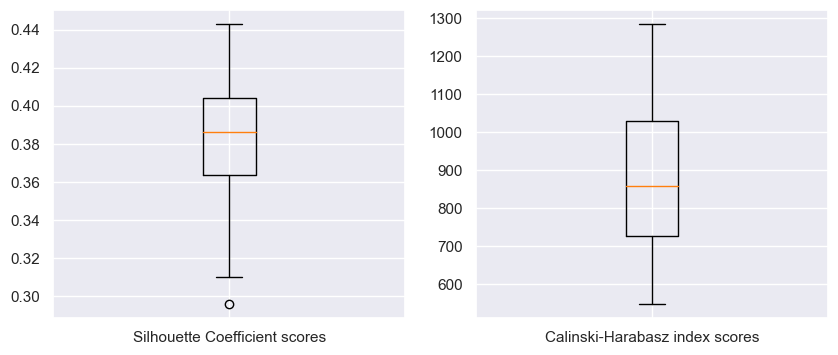

In [6]:
fig = plt.figure(figsize=(10, 4))
ax1, ax2 = fig.subplots(1, 2)
ax1.boxplot(results['silhouette'], labels=['Silhouette Coefficient scores'])
ax2.boxplot(results['calinski'], labels=['Calinski-Harabasz index scores'])

In [7]:
results.shape

(32, 6)

In [8]:
best_results = results.loc[(results['silhouette'] > 0.4) & (results['calinski'] > 1100)].sort_values(by='silhouette', ascending=False)
print(best_results)


               name  nfeat  clusters      inertia  silhouette     calinski
9         with DewP      4         3  2227.299316    0.443054  1183.767935
16  with Press DewP      5         2  3882.713135    0.426262  1285.993895
8         with DewP      4         2  3266.952881    0.422802  1150.908635
17  with Press DewP      5         3  2892.849365    0.411618  1111.881801
10        with DewP      4         4  1774.829346    0.408299  1113.514824


C:\Users\abhis\AppData\Local\Temp\ipykernel_11744\2173478859.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_11744\2173478859.py:70: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_11744\2173478859.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_11744\2173478859.py:70: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_11744\2173478859.py:67: 

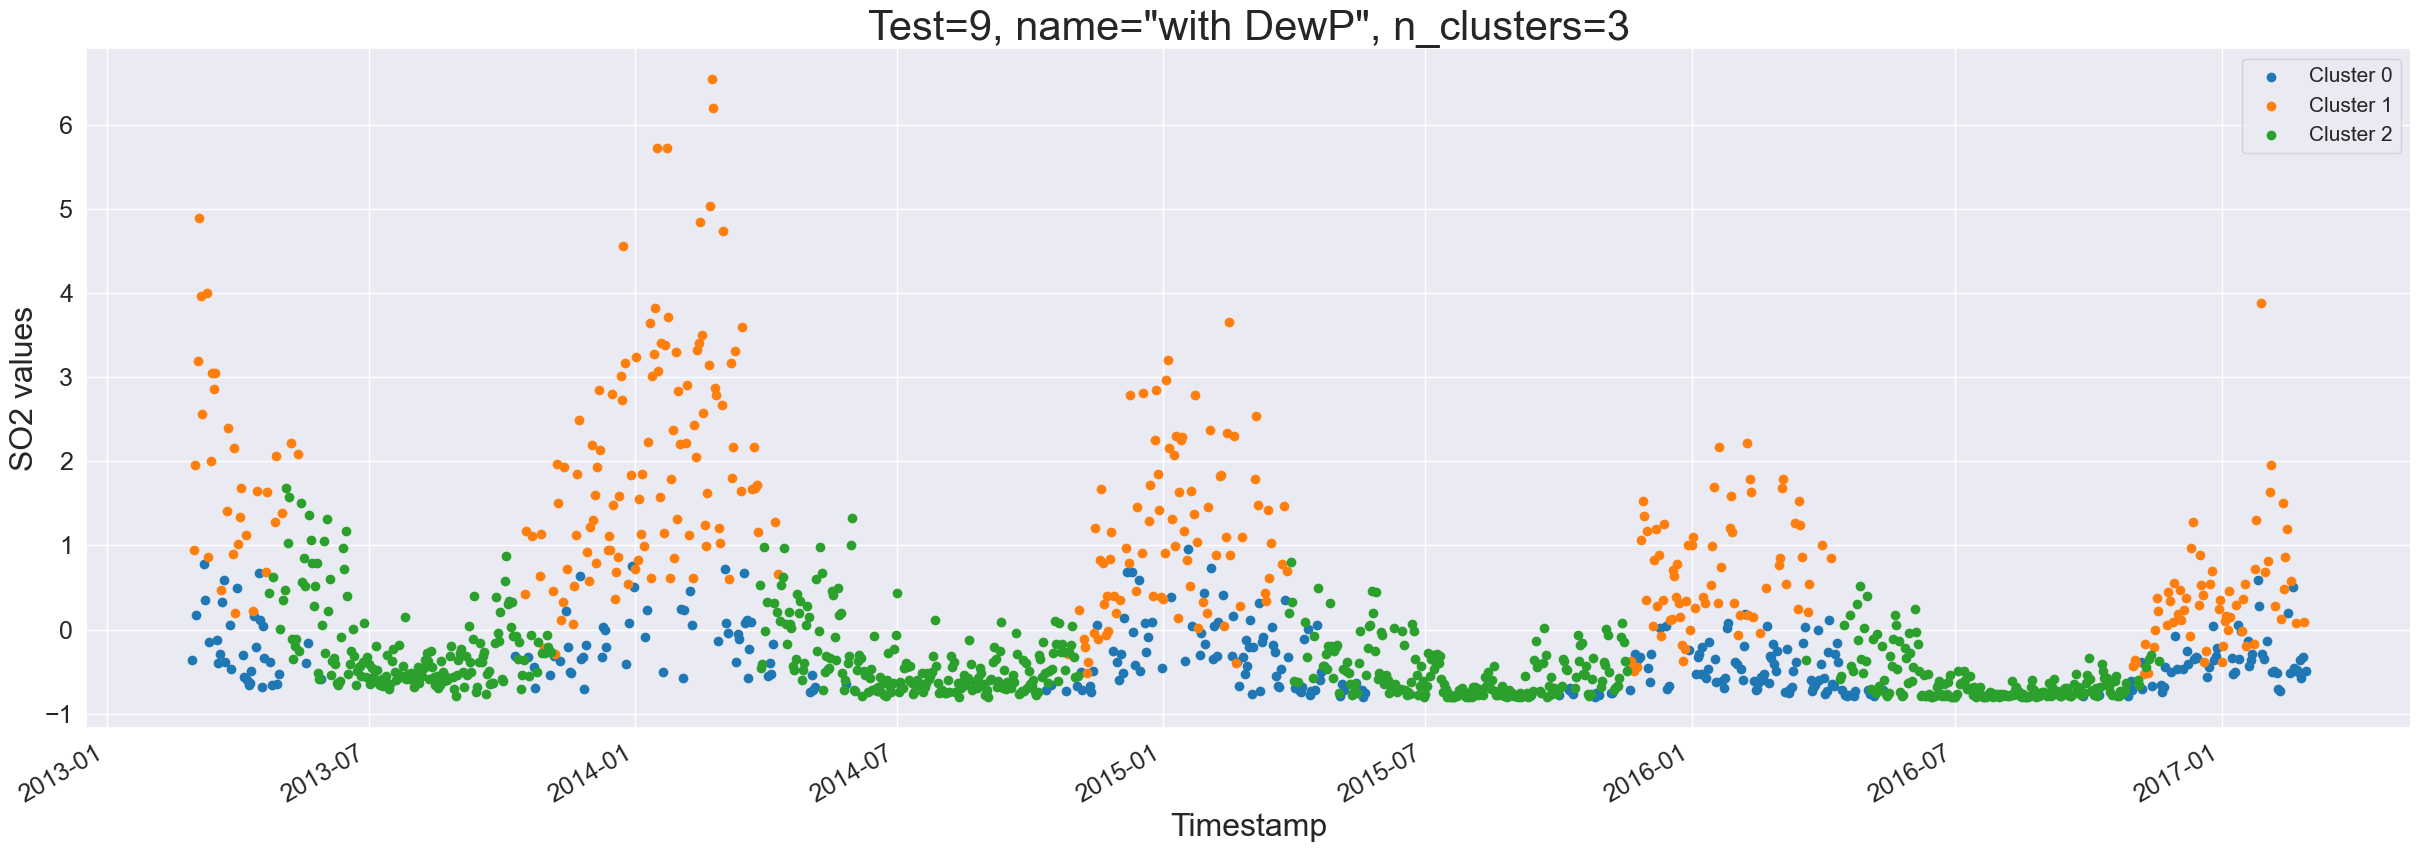

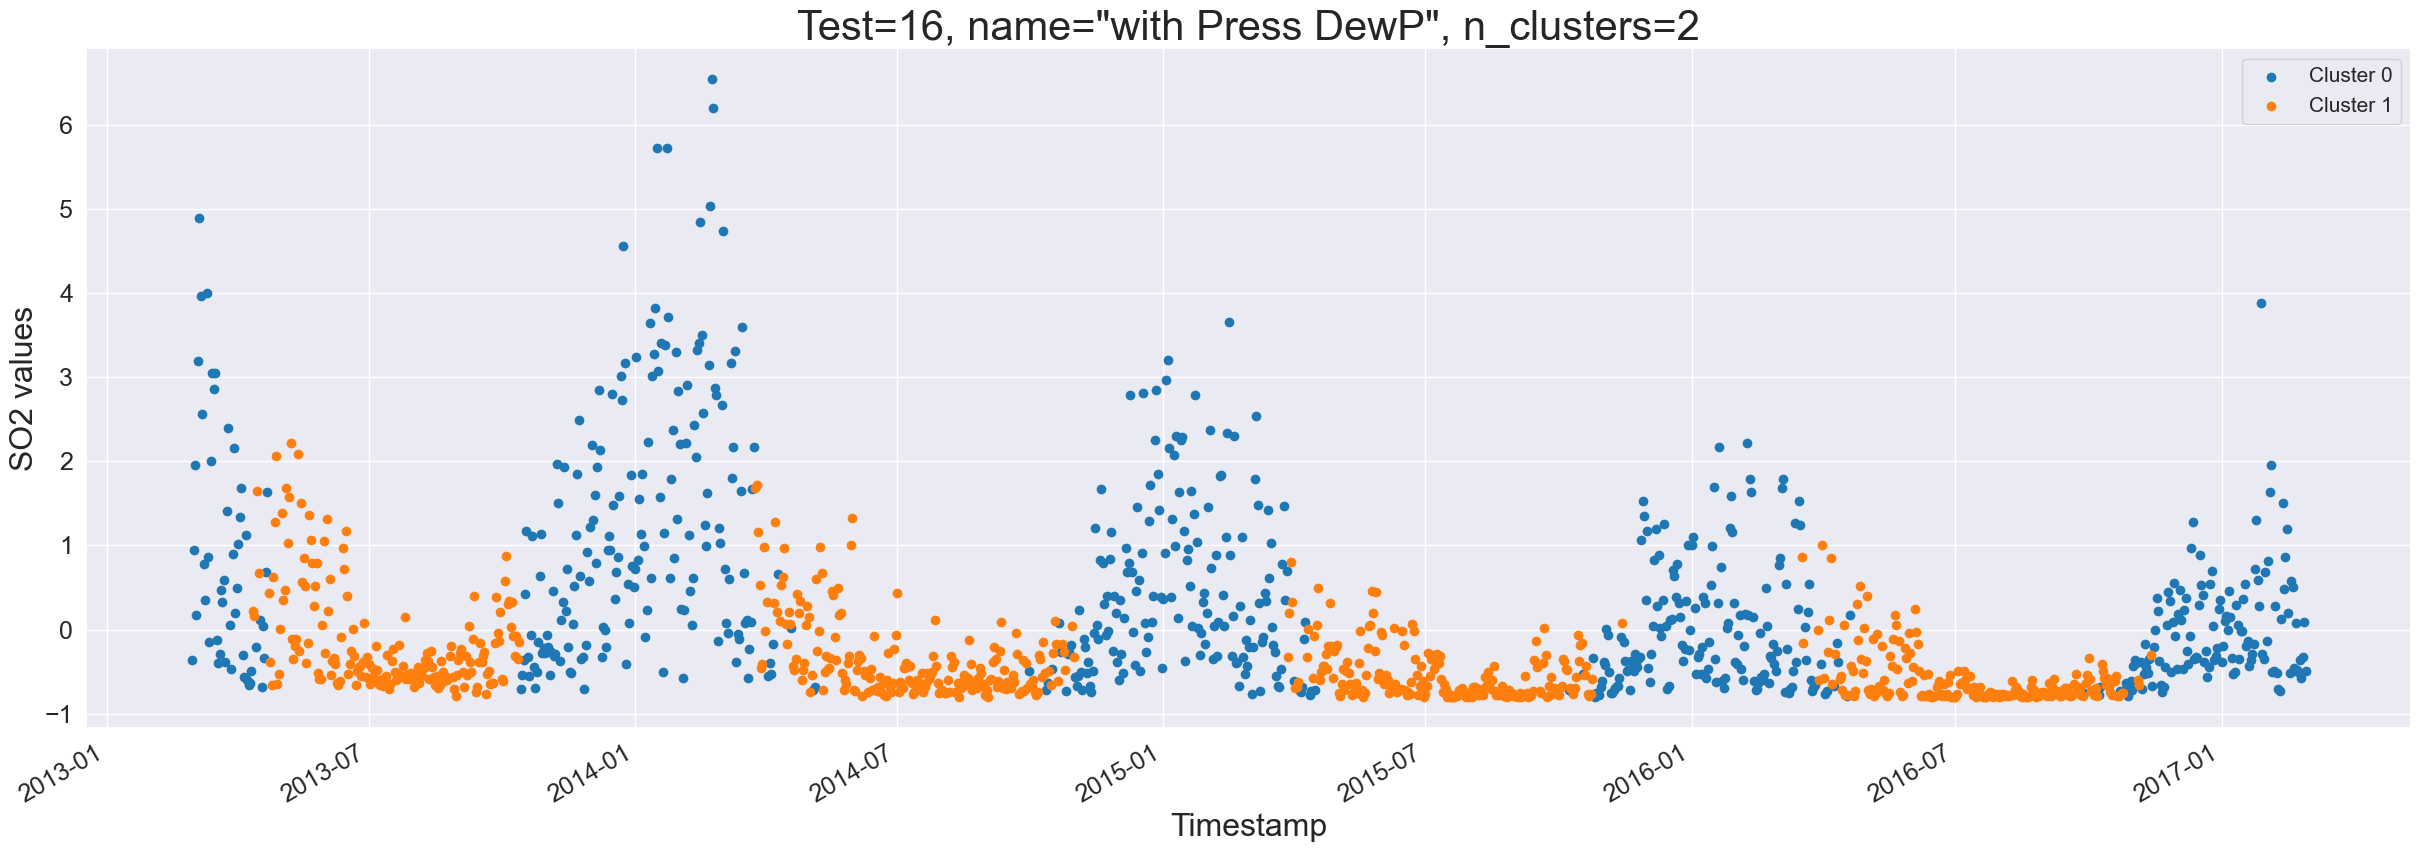

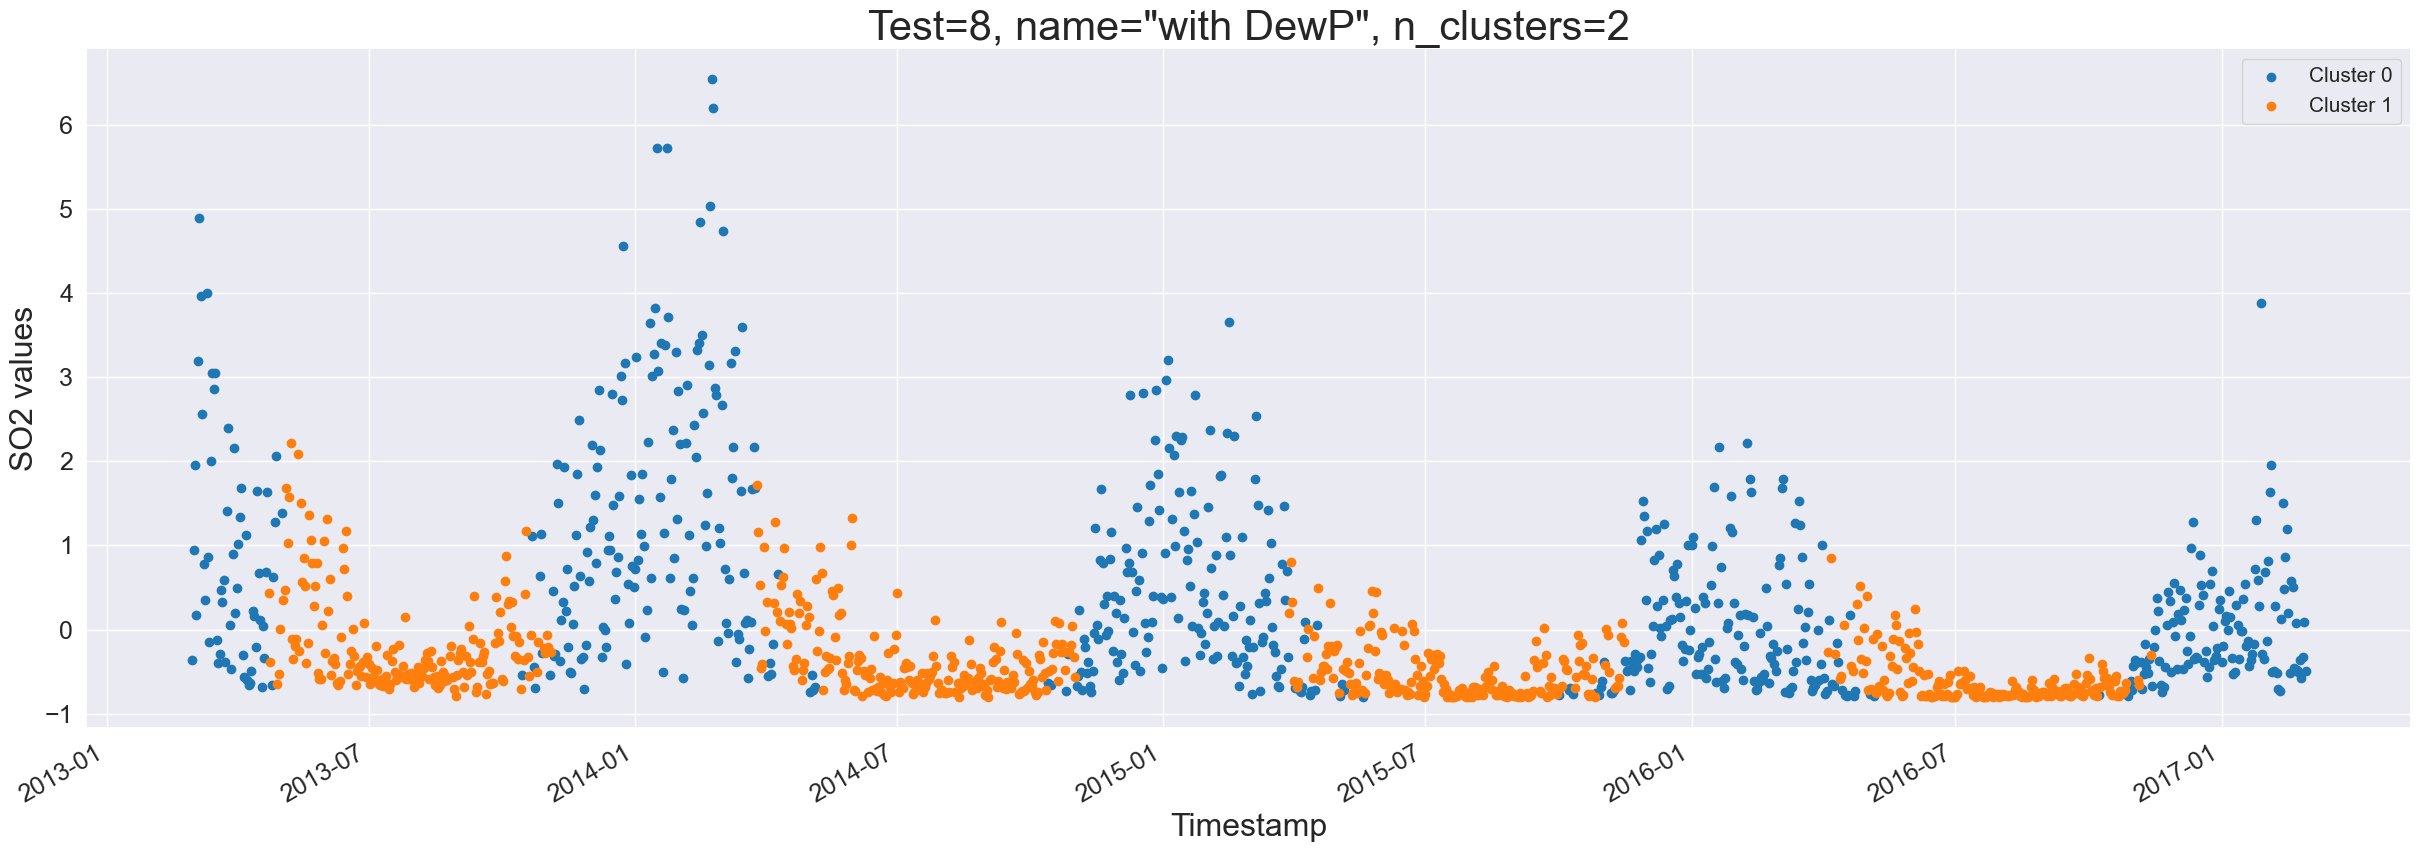

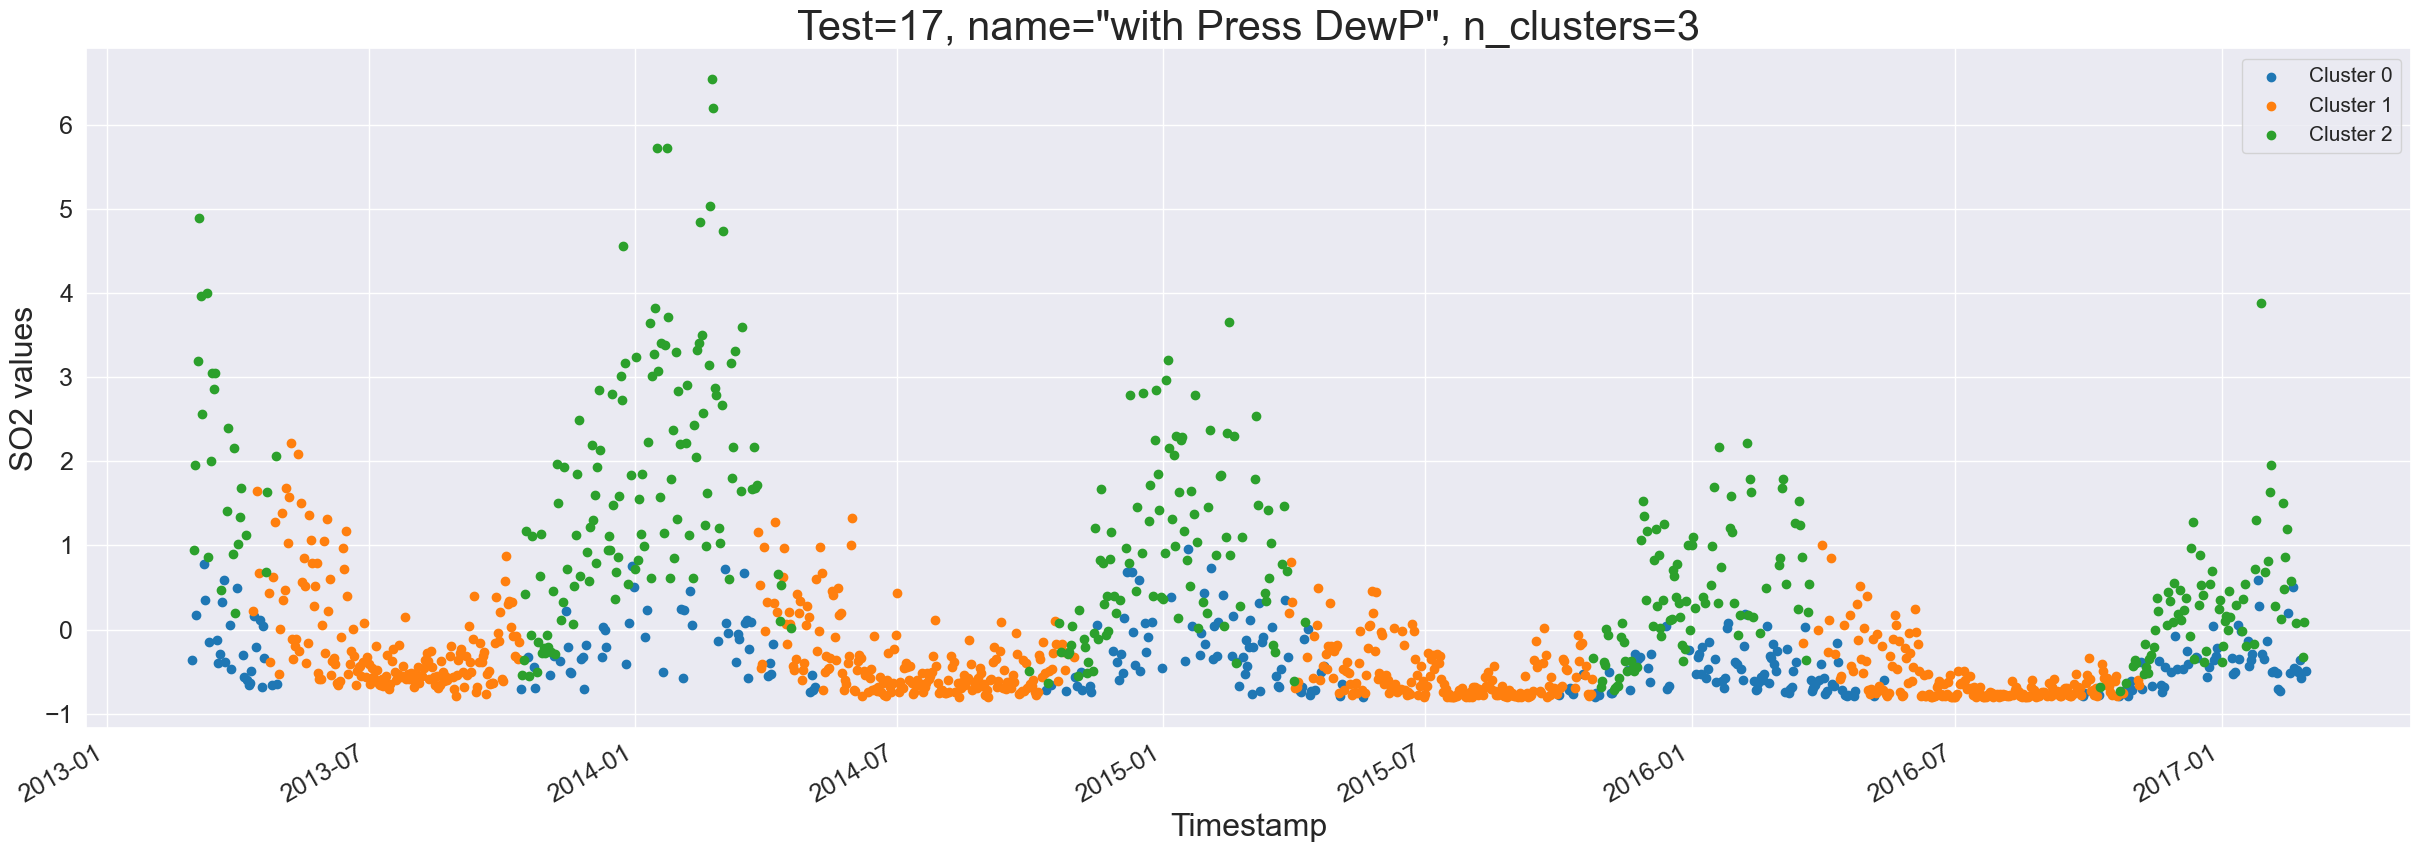

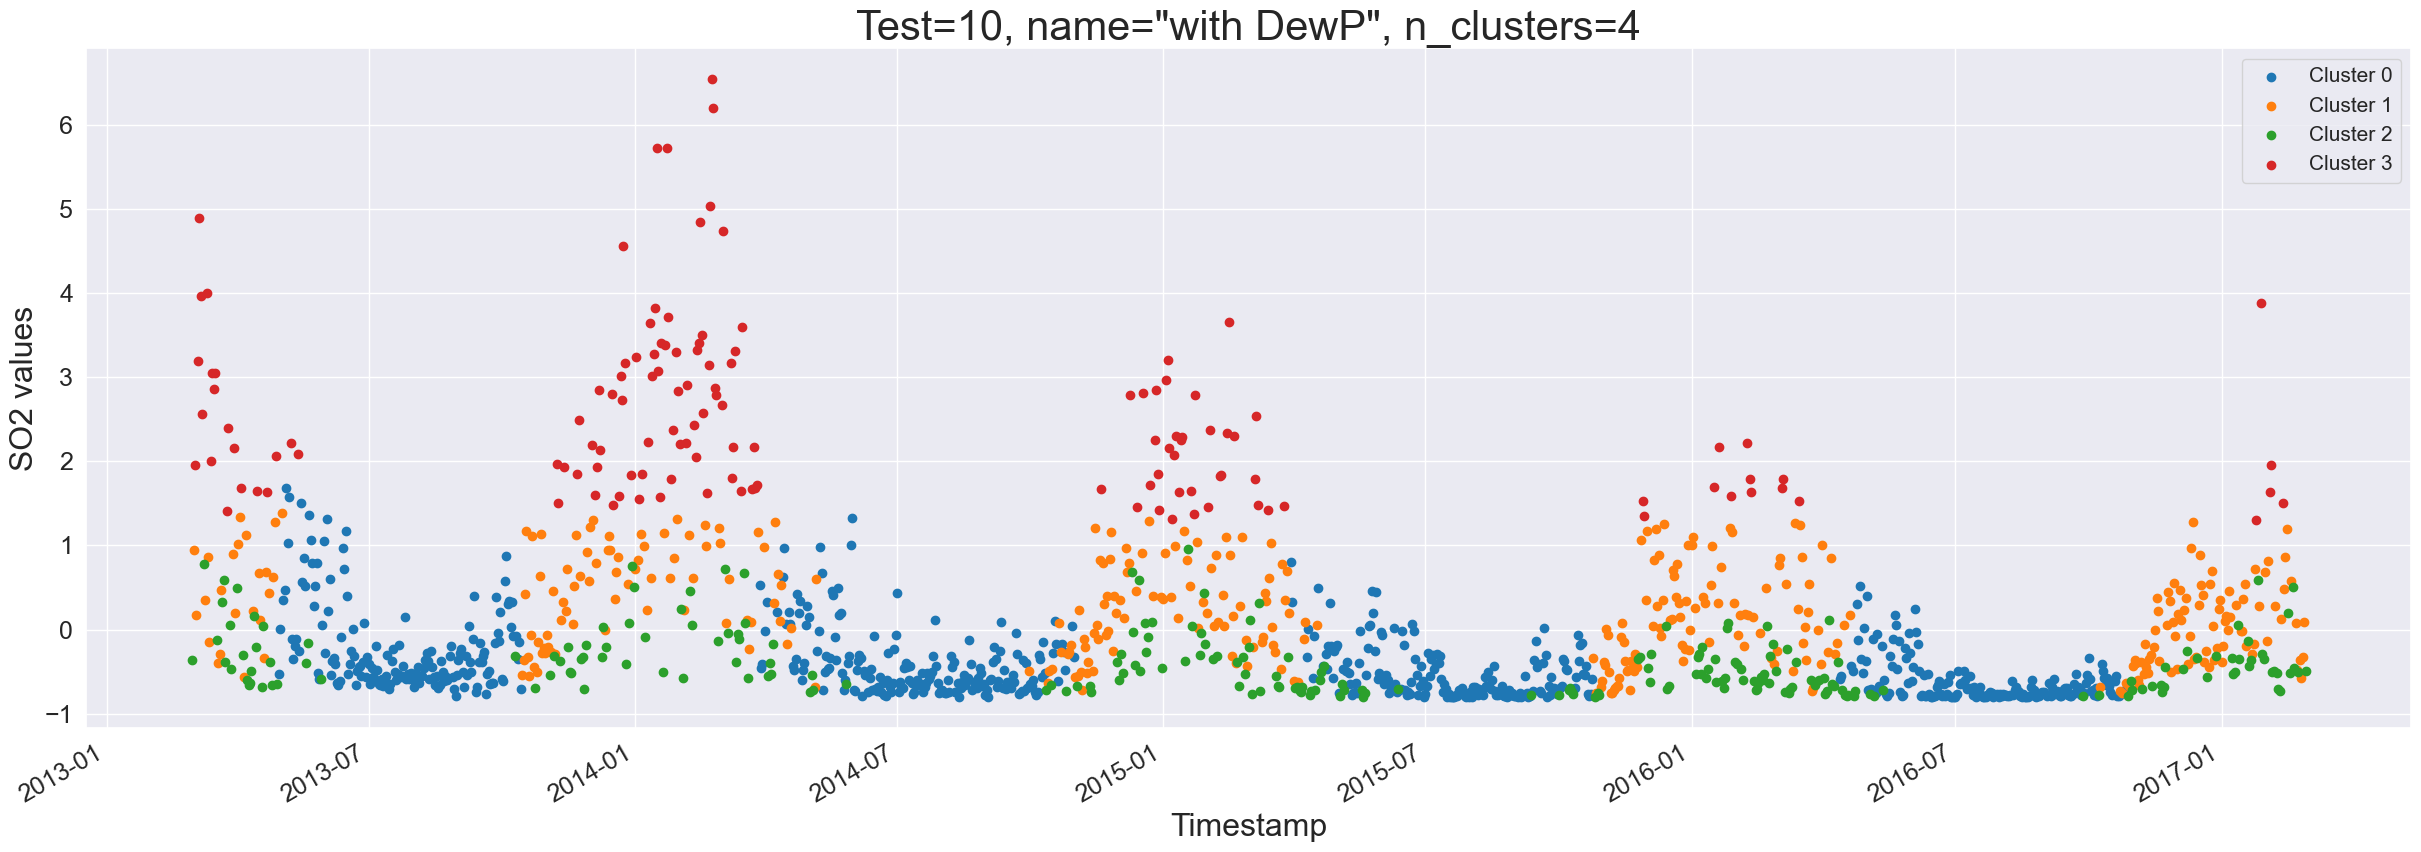

In [9]:
# Ploting clusters over the time series of the best models
for i in best_results.index:
    plot_ts_clusters_scatter(data_list[i], 'Test={}, name="{}", n_clusters={}'
                             .format(i, results.iloc[i, 0], results.iloc[i, 2]))